Purpose: from a given query text, we will encode this text and then retrieve it using a vector database (FAISS) to return k neighbor vectors (a vector representing an image) with the best similarity.

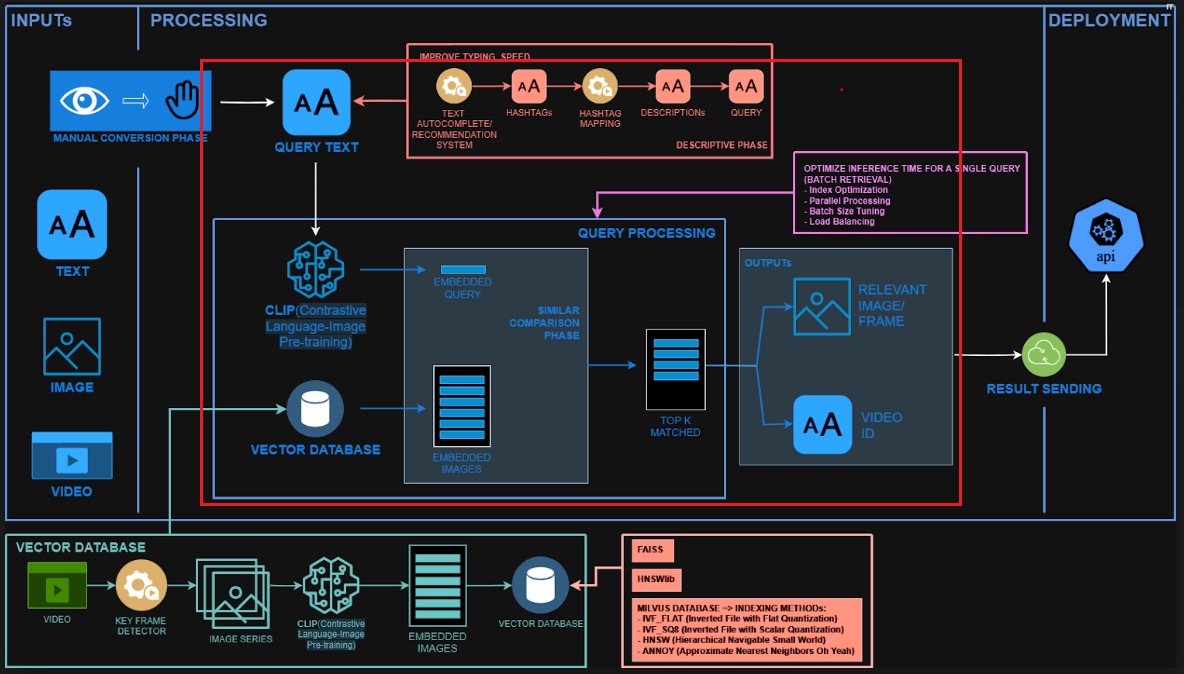

##Load sample

In [ ]:
#Load vector database
!gdown 1-2dpWfxx0Sgh1fPYhT6wdG_SNTXQO8z_
#Load annotation (original_video_paths)
!gdown 1-5d1QP_8tgv5A1A9TTzENjUpqfWaTF01
#Load annotation (index_image_video_dict)
!gdown 1-1FifKSgD_Yf10ucdBbS-l5QOctYiQ5d
#Load key frame folder
!gdown 1-1tNaT2IAaAcTbfdpNxiPVi7WJ87WubW

In [ ]:
import json
# Load annotation
with open('video_path_dict.json', 'r') as openfile:
  original_video_dict = json.load(openfile)
with open('index_image_video_dict.json', 'r') as openfile:
  index_image_video_dict = json.load(openfile)

In [ ]:
#Unzip keyframe folder
!unzip -q /content/key_frame_folder.zip
multiple_key_frame_folder = '/content/key_frame_folder'

##Load and set up database (using CPU)

In [ ]:
#!pip -q install faiss-gpu  # or faiss-cpu if you don't have GPU support
!pip -q install faiss-cpu
import faiss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 28.4 MB/s eta 0:00:00


In [ ]:
# Set the number of threads for search operations
import multiprocessing
# Get the number of threads
num_threads = multiprocessing.cpu_count()
print(f"Number of threads: {num_threads}")
# Set the number of threads to use
faiss.omp_set_num_threads(num_threads)

# memory-map the index file, allowing efficient access without loading the entire index into RAM
index_hnsw = faiss.read_index("merged_index_hnsw.bin", faiss.IO_FLAG_MMAP)

# Optionally configure the index parameters, to control the search behavior
#index_hnsw.nprobe = 32 # Number of clusters to search, for example

Number of threads: 2


##Query Encoding (using GPU)

In [ ]:
#Install CLIP
!pip -q install git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 901.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 49.4 MB/s eta 0:00:00


In [ ]:
import torch
import clip
#Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 194MiB/s]


In [ ]:
#Query Encoding with CLIP
def encode_description(description):
  # Tokenize and encode the description
  text_inputs = clip.tokenize([description]).to(device)
  with torch.no_grad():
      text_features = model.encode_text(text_inputs)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  query_vector = text_features #text_features.cpu().numpy()
  return query_vector

# Example description
description = "the plane on the sky"
query_vector = encode_description(description)
query_vector.shape

torch.Size([1, 512])

##Retrieval (using CPU)

In [ ]:
%%time
import numpy as np
k = 5  # Number of nearest neighbors

#Retrive using encoded description
if device == "cuda":
  vector_data = query_vector.cpu().numpy().astype(np.float32) #send to cpu to query
vector_data = query_vector
distances_hnsw, indices_hnsw = index_hnsw.search(vector_data, k) #query

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 15.7 ms


##Show the results

In [ ]:
import os
from PIL import Image

# Display results
def display_results(indices, index_image_video_dict, original_video_dict):
  for i, idx in enumerate(indices):
    print(f"Result {i + 1}:")
    print(f"Frame Index: {idx}")
    print(f"Image path: {index_image_video_dict[str(idx)][0]}")
    print(f"Video ID: {index_image_video_dict[str(idx)][1]} => Video path: {original_video_dict[index_image_video_dict[str(idx)][1]]}")
    img = Image.open(index_image_video_dict[str(idx)][0]).convert(mode="RGB")
    display(img)

Result 1:
Frame Index: 105
Image path: /content/key_frame_folder/key_frame_New_truyenhinhnhandantv/New_truyenhinhnhandantv_1620_1680_0.jpeg
Video ID: New_truyenhinhnhandantv => Video path: ./video_folder/New_truyenhinhnhandantv.mp4


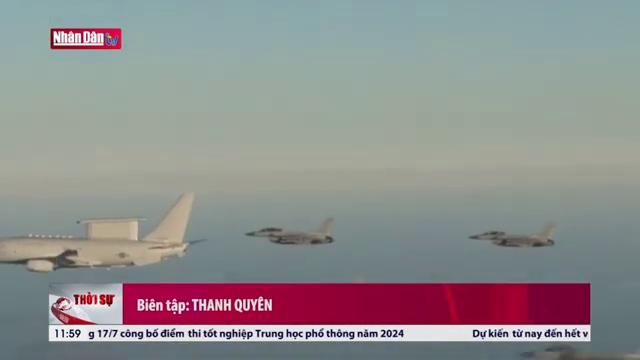

Result 2:
Frame Index: 128
Image path: /content/key_frame_folder/key_frame_New_truyenhinhnhandantv/New_truyenhinhnhandantv_480_540_2.jpeg
Video ID: New_truyenhinhnhandantv => Video path: ./video_folder/New_truyenhinhnhandantv.mp4


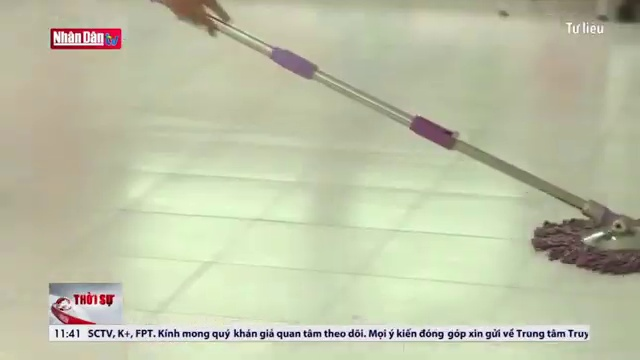

Result 3:
Frame Index: 102
Image path: /content/key_frame_folder/key_frame_New_truyenhinhnhandantv/New_truyenhinhnhandantv_1560_1620_0.jpeg
Video ID: New_truyenhinhnhandantv => Video path: ./video_folder/New_truyenhinhnhandantv.mp4


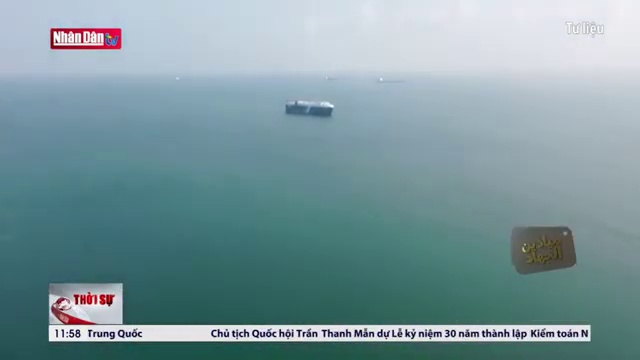

Result 4:
Frame Index: 97
Image path: /content/key_frame_folder/key_frame_New_truyenhinhnhandantv/New_truyenhinhnhandantv_1440_1500_1.jpeg
Video ID: New_truyenhinhnhandantv => Video path: ./video_folder/New_truyenhinhnhandantv.mp4


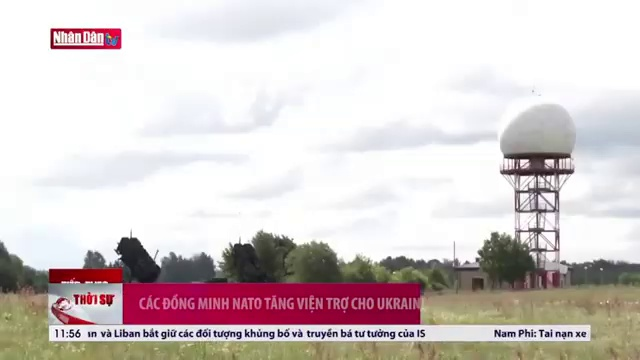

Result 5:
Frame Index: 94
Image path: /content/key_frame_folder/key_frame_New_truyenhinhnhandantv/New_truyenhinhnhandantv_1380_1440_1.jpeg
Video ID: New_truyenhinhnhandantv => Video path: ./video_folder/New_truyenhinhnhandantv.mp4


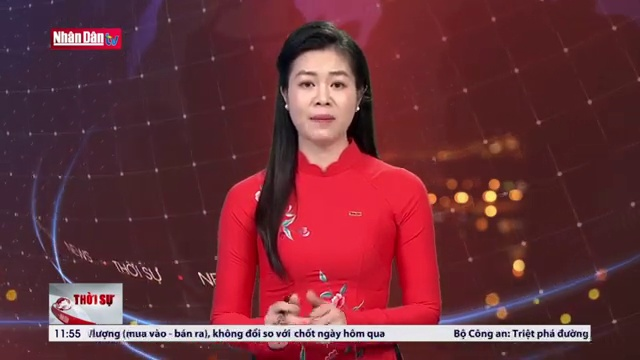

In [ ]:
# Display results
display_results(indices_hnsw[0], index_image_video_dict, original_video_dict)